<a href="https://colab.research.google.com/github/walnuthoram2/VRP-MILP-ALNS/blob/main/VRP_ALNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github

https://alns.readthedocs.io/en/latest/examples/capacitated_vehicle_routing_problem.html

#Data 불러오기

In [34]:
!pip install alns

In [35]:
!pip install 'alns @ git+https://github.com/walnuthoram2/alns'

  Cloning https://github.com/walnuthoram2/alns to /tmp/pip-install-mveri2ej/alns_1b77a8e744bc49cda66c8bc0b375f728
  Running command git clone --filter=blob:none --quiet https://github.com/walnuthoram2/alns /tmp/pip-install-mveri2ej/alns_1b77a8e744bc49cda66c8bc0b375f728
  Resolved https://github.com/walnuthoram2/alns to commit 8ba825e8c435d5f3a9ef1622cf175b90fe5952ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [36]:
import copy
from types import SimpleNamespace

import vrplib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import RouletteWheel
from alns.stop import MaxIterations

In [37]:
!pip install vrplib

In [38]:
%matplotlib inline

In [39]:
SEED = 1234

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/My Drive/data/ORTEC-n242-k12.vrp"
if os.path.exists(file_path):
    print(f"파일 {file_path} 존재함")
else:
    print(f"파일 {file_path} 없음. 경로를 확인하세요.")

In [54]:
data = vrplib.read_instance("/content/drive/My Drive/data/ORTEC-n242-k12.vrp")
bks = SimpleNamespace(**vrplib.read_solution("/content/drive/My Drive/data/ORTEC-n242-k12.sol"))

In [56]:
def plot_solution(solution, name="CVRP solution"):
    """
    Plot the routes of the passed-in solution.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = matplotlib.cm.rainbow(np.linspace(0, 1, len(solution.routes)))

    for idx, route in enumerate(solution.routes):
        ax.plot(
            [data["node_coord"][loc][0] for loc in [0] + route + [0]],
            [data["node_coord"][loc][1] for loc in [0] + route + [0]],
            color=cmap[idx],
            marker=".",
        )

    # Plot the depot
    kwargs = dict(label="Depot", zorder=3, marker="*", s=750)
    ax.scatter(*data["node_coord"][0], c="tab:red", **kwargs)

    ax.set_title(f"{name}\n Total distance: {solution.cost}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)

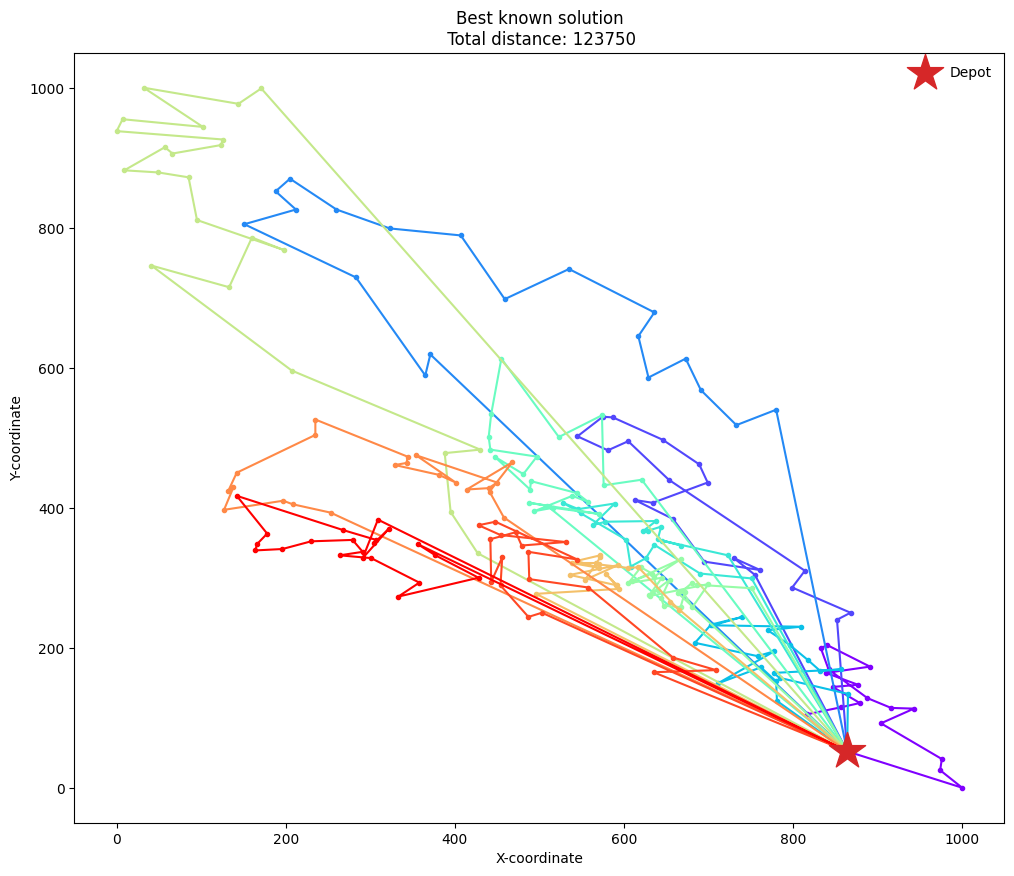

In [57]:
plot_solution(bks, name="Best known solution")

# solution 상태

In [58]:
class CvrpState:
    """
    Solution state for CVRP. It has two data members, routes and unassigned.
    Routes is a list of list of integers, where each inner list corresponds to
    a single route denoting the sequence of customers to be visited. A route
    does not contain the start and end depot. Unassigned is a list of integers,
    each integer representing an unassigned customer.
    """

    def __init__(self, routes, unassigned=None):
        self.routes = routes
        self.unassigned = unassigned if unassigned is not None else []

    def copy(self):
        return CvrpState(copy.deepcopy(self.routes), self.unassigned.copy())

    def objective(self):
        """
        Computes the total route costs.
        """
        return sum(route_cost(route) for route in self.routes)

    @property
    def cost(self):
        """
        Alias for objective method. Used for plotting.
        """
        return self.objective()

    def find_route(self, customer):
        """
        Return the route that contains the passed-in customer.
        """
        for route in self.routes:
            if customer in route:
                return route

        raise ValueError(f"Solution does not contain customer {customer}.")


def route_cost(route):
    distances = data["edge_weight"]
    tour = [0] + route + [0]

    return sum(
        distances[tour[idx]][tour[idx + 1]] for idx in range(len(tour) - 1)
    )

# Destroy operators

In [59]:
degree_of_destruction = 0.05
customers_to_remove = int((data["dimension"] - 1) * degree_of_destruction)

In [60]:
def random_removal(state, rng):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    destroyed = state.copy()

    for customer in rng.choice(
        range(1, data["dimension"]), customers_to_remove, replace=False
    ):
        destroyed.unassigned.append(customer)
        route = destroyed.find_route(customer)
        route.remove(customer)

    return remove_empty_routes(destroyed)


def remove_empty_routes(state):
    """
    Remove empty routes after applying the destroy operator.
    """
    state.routes = [route for route in state.routes if len(route) != 0]
    return state

#Repair operatiors

In [61]:
def greedy_repair(state, rng):
    """
    Inserts the unassigned customers in the best route. If there are no
    feasible insertions, then a new route is created.
    """
    rng.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        customer = state.unassigned.pop()
        route, idx = best_insert(customer, state)

        if route is not None:
            route.insert(idx, customer)
        else:
            state.routes.append([customer])

    return state


def best_insert(customer, state):
    """
    Finds the best feasible route and insertion idx for the customer.
    Return (None, None) if no feasible route insertions are found.
    """
    best_cost, best_route, best_idx = None, None, None

    for route in state.routes:
        for idx in range(len(route) + 1):

            if can_insert(customer, route):
                cost = insert_cost(customer, route, idx)

                if best_cost is None or cost < best_cost:
                    best_cost, best_route, best_idx = cost, route, idx

    return best_route, best_idx


def can_insert(customer, route):
    """
    Checks if inserting customer does not exceed vehicle capacity.
    """
    total = data["demand"][route].sum() + data["demand"][customer]
    return total <= data["capacity"]


def insert_cost(customer, route, idx):
    """
    Computes the insertion cost for inserting customer in route at idx.
    """
    dist = data["edge_weight"]
    pred = 0 if idx == 0 else route[idx - 1]
    succ = 0 if idx == len(route) else route[idx]

    # Increase in cost of adding customer, minus cost of removing old edge
    return dist[pred][customer] + dist[customer][succ] - dist[pred][succ]

#Initial solution

In [62]:
def neighbors(customer):
    """
    Return the nearest neighbors of the customer, excluding the depot.
    """
    locations = np.argsort(data["edge_weight"][customer])
    return locations[locations != 0]


def nearest_neighbor():
    """
    Build a solution by iteratively constructing routes, where the nearest
    customer is added until the route has met the vehicle capacity limit.
    """
    routes = []
    unvisited = set(range(1, data["dimension"]))

    while unvisited:
        route = [0]  # Start at the depot
        route_demands = 0

        while unvisited:
            # Add the nearest unvisited customer to the route till max capacity
            current = route[-1]
            nearest = [nb for nb in neighbors(current) if nb in unvisited][0]

            if route_demands + data["demand"][nearest] > data["capacity"]:
                break

            route.append(nearest)
            unvisited.remove(nearest)
            route_demands += data["demand"][nearest]

        customers = route[1:]  # Remove the depot
        routes.append(customers)

    return CvrpState(routes)

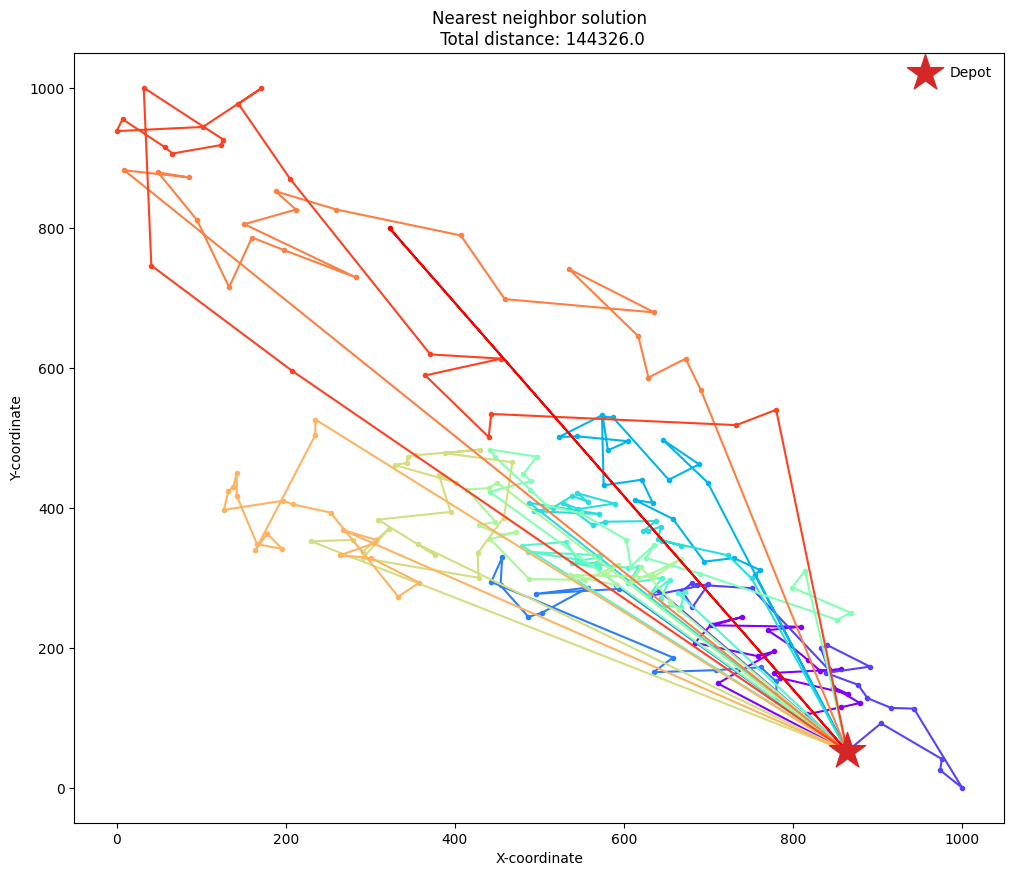

In [63]:
plot_solution(nearest_neighbor(), "Nearest neighbor solution")

#Heuristic solution

In [64]:
alns = ALNS(rnd.default_rng(SEED))

alns.add_destroy_operator(random_removal)

alns.add_repair_operator(greedy_repair)

In [65]:
num_iterations = 3000
init = nearest_neighbor()
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = RecordToRecordTravel.autofit(
    init.objective(), 0.02, 0, num_iterations
)
stop = MaxIterations(num_iterations)

result = alns.iterate(init, select, accept, stop)

In [66]:
solution = result.best_state
objective = solution.objective()
pct_diff = 100 * (objective - bks.cost) / bks.cost

print(f"Best heuristic objective is {objective}.")
print(
    f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bks.cost}."
)

Best heuristic objective is 135555.0.
This is 9.5% worse than the optimal solution, which is 123750.


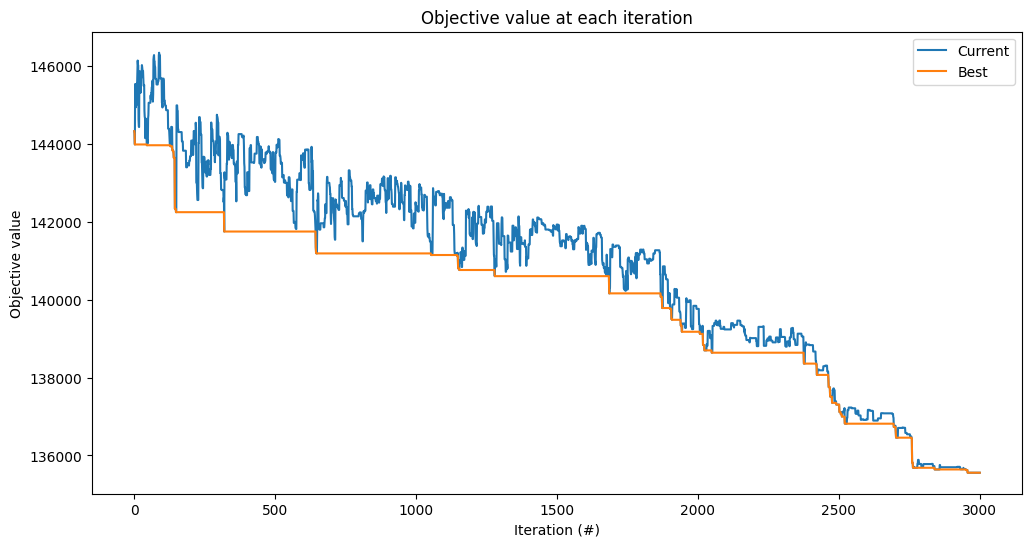

In [67]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

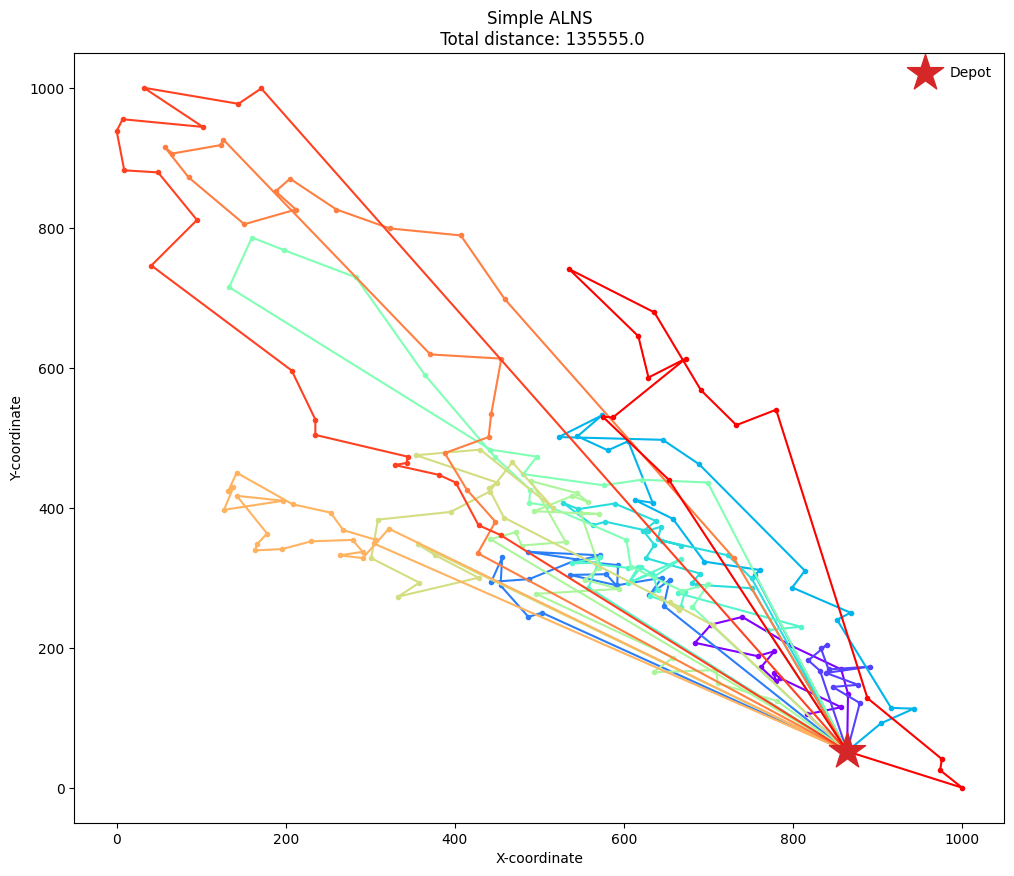

In [68]:
plot_solution(solution, "Simple ALNS")

#Slack-induced substring removal

In [ ]:
MAX_STRING_REMOVALS = 2
MAX_STRING_SIZE = 12


def string_removal(state, rng):
    """
    Remove partial routes around a randomly chosen customer.
    """
    destroyed = state.copy()

    avg_route_size = int(np.mean([len(route) for route in state.routes]))
    max_string_size = max(MAX_STRING_SIZE, avg_route_size)
    max_string_removals = min(len(state.routes), MAX_STRING_REMOVALS)

    destroyed_routes = []
    center = rng.integers(1, data["dimension"])

    for customer in neighbors(center):
        if len(destroyed_routes) >= max_string_removals:
            break

        if customer in destroyed.unassigned:
            continue

        route = destroyed.find_route(customer)
        if route in destroyed_routes:
            continue

        customers = remove_string(route, customer, max_string_size, rng)
        destroyed.unassigned.extend(customers)
        destroyed_routes.append(route)

    return destroyed


def remove_string(route, cust, max_string_size, rng):
    """
    Remove a string that constains the passed-in customer.
    """
    # Find consecutive indices to remove that contain the customer
    size = rng.integers(1, min(len(route), max_string_size) + 1)
    start = route.index(cust) - rng.integers(size)
    idcs = [idx % len(route) for idx in range(start, start + size)]

    # Remove indices in descending order
    removed_customers = []
    for idx in sorted(idcs, reverse=True):
        removed_customers.append(route.pop(idx))

    return removed_customers

In [ ]:
alns = ALNS(rnd.default_rng(SEED))

alns.add_destroy_operator(string_removal)

alns.add_repair_operator(greedy_repair)

In [ ]:
num_iterations = 3000
init = nearest_neighbor()
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = RecordToRecordTravel.autofit(
    init.objective(), 0.02, 0, num_iterations
)
stop = MaxIterations(num_iterations)

result = alns.iterate(init, select, accept, stop)

In [ ]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

In [ ]:
solution = result.best_state
objective = solution.objective()
pct_diff = 100 * (objective - bks.cost) / bks.cost

print(f"Best heuristic objective is {objective}.")
print(
    f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bks.cost}."
)
plot_solution(solution, "String removals")

#Conclusion

**Conclusions**

In this notebook we implemented two heuristics for the CVRP, using the ALNS meta-heuristic framework.

The first heuristic used a random customer destroy operator and we obtained a solution which is 10% worse than the best known solution.

The second heuristic used a destroy operator which removes strings arround a randomly selected customer and we obtained a solution that is only 3% worse than the best known solution.

This example shows that by constructing problem-specific operators, one can create even more powerful ALNS heuristics.